# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a [logistic model](https://en.wikipedia.org/wiki/Logistic_function), provided by [Pints's toy model module](http://pints.readthedocs.io/en/latest/toy/index.html).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 100)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [6]:
import matplotlib.pyplot as plt

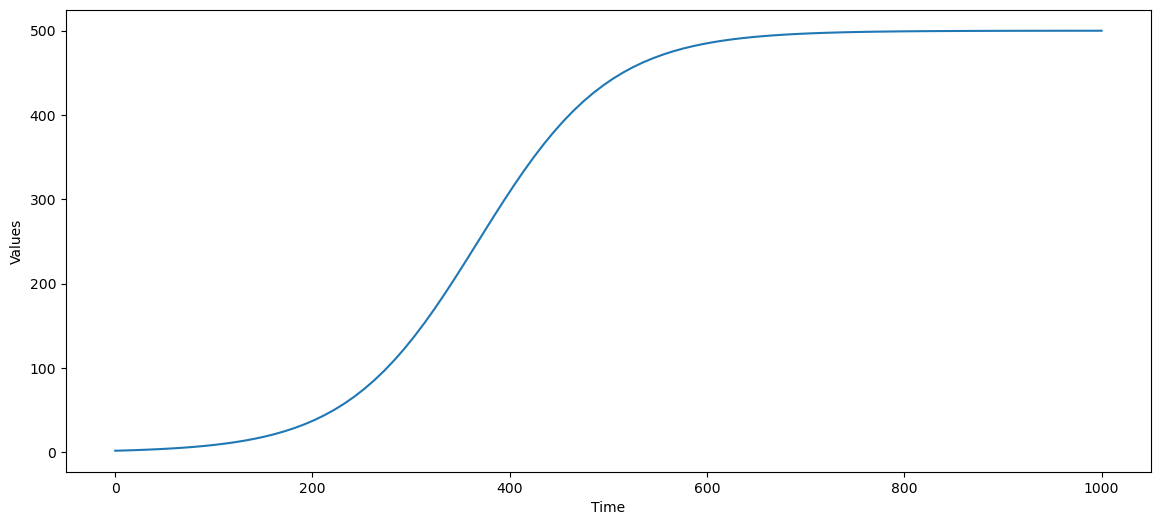

In [7]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

We then define an [error measure](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [9]:
error = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [10]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [11]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [12]:
found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4333739   4333739    0:00.0
1     12     4183608   4183608    0:00.0
2     16     4183608   4259524    0:00.0
3     21     4067444   4067444    0:00.0
20    110    878913.1  2875801    0:00.0
40    226    7082.994  12640.49   0:00.1
60    346    2.782674  31.67728   0:00.1
80    466    0.0032    0.00564    0:00.1
100   586    2.15e-06  3.48e-05   0:00.1
120   706    5.28e-09  2.58e-08   0:00.1
140   826    1.94e-11  2.99e-11   0:00.2
160   946    6.75e-15  1.39e-14   0:00.2
180   1066   1.92e-17  6.25e-17   0:00.2
200   1186   7.37e-21  1.36e-20   0:00.2
220   1306   3.53e-23  2.07e-22   0:00.2
240   1426   0         2.84e-25   0:00.3
260   1546   0         0          0:00.3
280   1666   0         0          0:00.3
300   1786   0         0          0:00.4
320   1906   0         0          0:00.4
340   2026   0 

We can now look at the quality of the fit by running a simulation with the obtained parameters and plotting it on top of the noisy data:

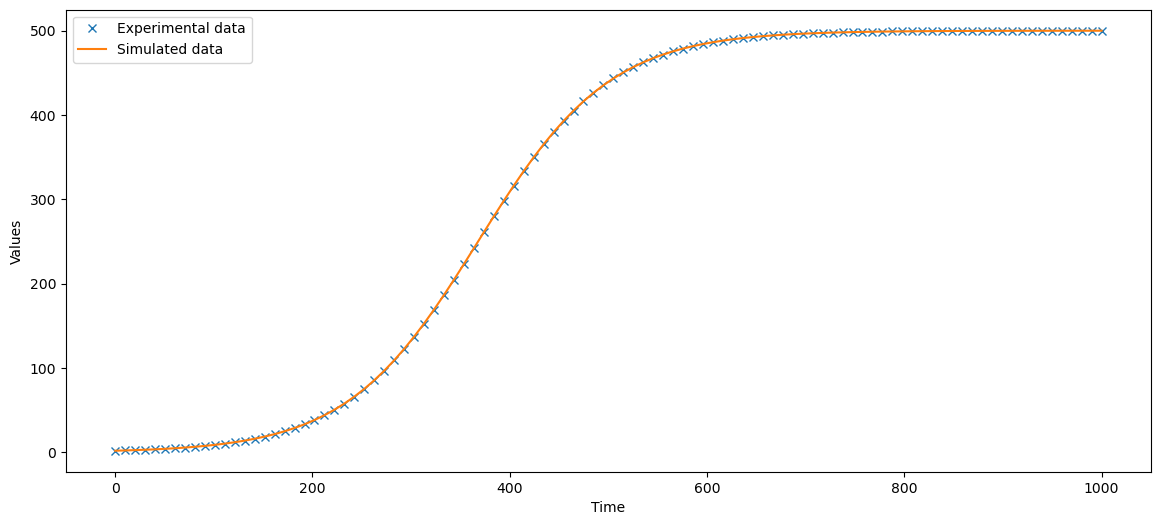

In [13]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, 'x', label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Because this was a toy model, we can also compare the parameters with the known true parameters:

In [14]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.49999999999999994e-02     1.49999999999999994e-02
 5.00000000000000000e+02     5.00000000000000000e+02


## Fitting to noisy data

We now repeat this exercise with noisy data:

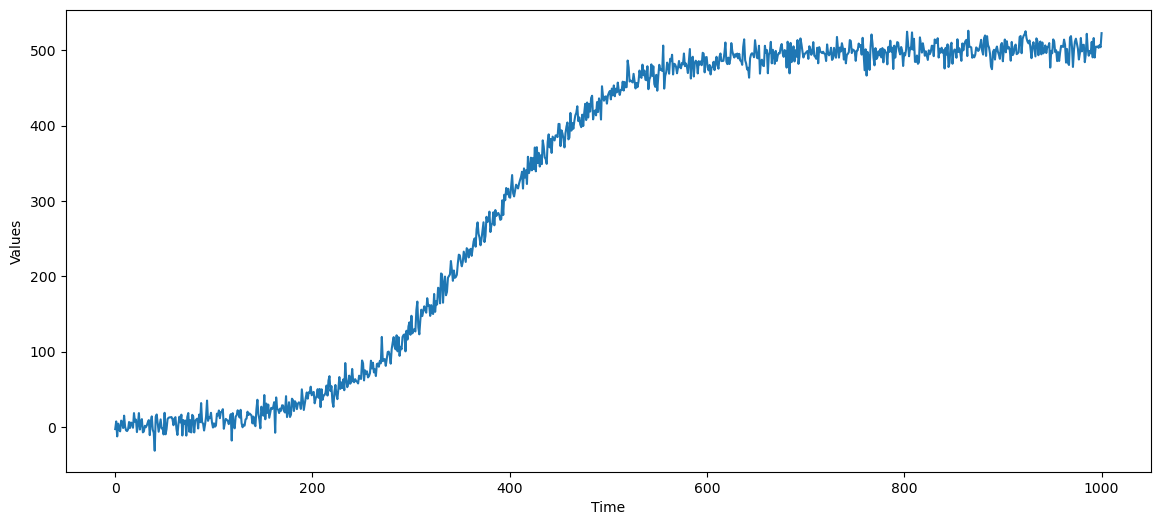

In [15]:
times = np.linspace(0, 1000, 1000)

values = model.simulate(real_parameters, times)
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

Again, we set up a problem, define an error measure, and run the optimisation:

In [16]:
problem = pints.SingleOutputProblem(model, times, values)
error = pints.SumOfSquaresError(problem)

found_parameters, found_value = pints.optimise(
    error,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      3.93e+07  3.93e+07   0:00.0
1     11     3.93e+07  4.06e+07   0:00.0
2     15     3.93e+07  4.09e+07   0:00.0
3     19     3.93e+07  4.24e+07   0:00.0
20    108    1.81e+07  1.81e+07   0:00.0
40    220    188756.3  978410.4   0:00.1
60    340    106229.6  106282.6   0:00.1
80    460    106213.5  106213.5   0:00.1
100   580    106213.5  106213.5   0:00.1
120   700    106213.5  106213.5   0:00.1
140   820    106213.5  106213.5   0:00.2
160   940    106213.5  106213.5   0:00.2
180   1060   106213.5  106213.5   0:00.2
200   1180   106213.5  106213.5   0:00.2
220   1300   106213.5  106213.5   0:00.3
240   1420   106213.5  106213.5   0:00.3
260   1540   106213.5  106213.5   0:00.3
280   1660   106213.5  106213.5   0:00.3
300   1780   106213.5  106213.5   0:00.4
320   1900   106213.5  106213.5   0:00.4
340   2020   10

And we can inspect the result by plotting a simulation:

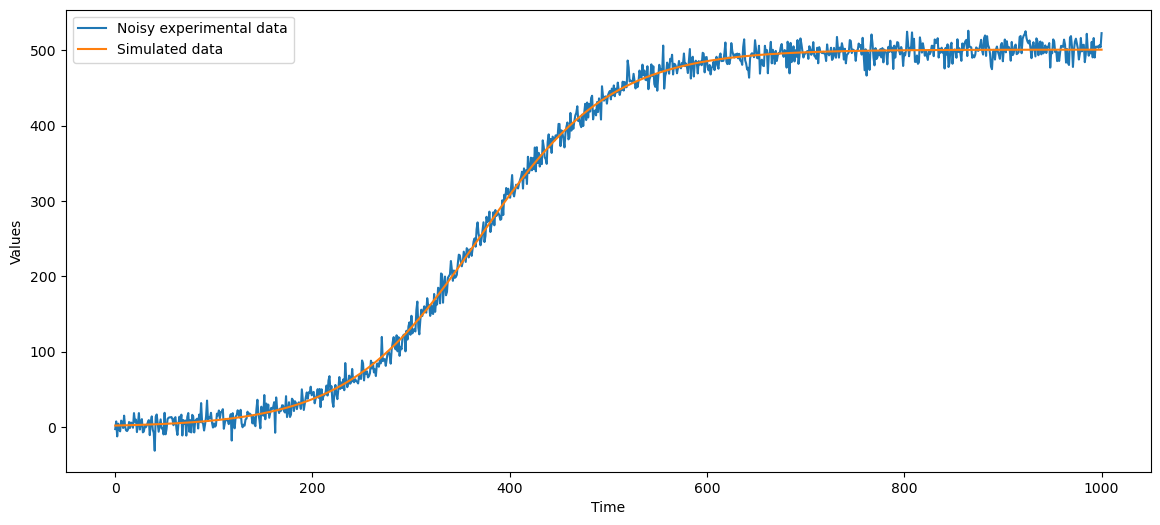

In [17]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()

Looks like a great fit!

Because it's still a toy problem, we can look at the parameter values as well:

In [18]:
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Found solution:          True parameters:
 1.49674088587464799e-02     1.49999999999999994e-02
 5.00631470039650537e+02     5.00000000000000000e+02


So it looks like we were close, but not _exactly_ at the right parameters.

Why didn't we find _exactly_ the right solution in the noisy case?

To investigate this, we start by looking at the error measure, evaluated at the true solution and at the obtained solution:

In [19]:
print('Error at obtained solution: ')
print(error(found_parameters))

print('Error at true solution: ')
print(error(real_parameters))

Error at obtained solution: 
106213.5093342728
Error at true solution: 
106621.57365747471


Another way to compare them is to plot the error function on a line drawn between these points:

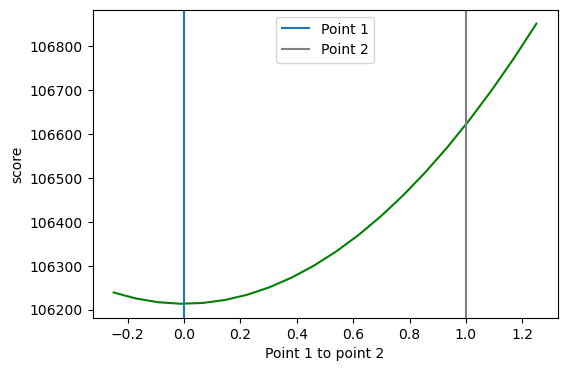

In [20]:
import pints.plot
fig, axes = pints.plot.function_between_points(error, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

So it looks like we found a solution that's slightly _better_ than the true solution - how can that be?

The answer comes from the noise we added to our data: it seems the optimiser is able to adjust the model parameters _so that the model reproduces some aspects of the noise signal_.

If we re-run this example (with a different random seed) we'll obtain an error of a slightly different size and direction.
In other words, we can treat our noise as a [finite sample from some distribution](https://en.wikipedia.org/wiki/Sampling_distribution) (in this case a Normal distribution), so that the parameters we infer from this noisy signal will have a slight randomness that should (on average) get worse with an increased variance (noise amplitude) but better with an increased sample size (higher sampling rate).

## Using the "controller" interface to change optimiser settings

In the examples above we ran the optimisation using [`pints.optimise`](https://pints.readthedocs.io/en/stable/optimisers/running.html#pints.optimise).
This is OK for small problems, but for many applications we prefer the extra control offered by the [`OptimisationController`](https://pints.readthedocs.io/en/stable/optimisers/running.html#pints.OptimisationController) class.

This is slightly more verbose:

In [21]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4.41e+07  4.41e+07   0:00.0
1     11     4.13e+07  4.13e+07   0:00.0
2     17     4.13e+07  4.39e+07   0:00.0
3     21     4.06e+07  4.06e+07   0:00.0
20    118    2.26e+07  3.19e+07   0:00.1
40    222    123752.8  726957.2   0:00.1
60    342    106313.5  107041.2   0:00.1
80    462    106213.6  106213.7   0:00.1
100   582    106213.5  106213.5   0:00.2
120   702    106213.5  106213.5   0:00.2
140   822    106213.5  106213.5   0:00.2
160   942    106213.5  106213.5   0:00.2
180   1062   106213.5  106213.5   0:00.3
200   1182   106213.5  106213.5   0:00.3
220   1302   106213.5  106213.5   0:00.3
240   1422   106213.5  106213.5   0:00.3
260   1542   106213.5  106213.5   0:00.3
280   1662   106213.5  106213.5   0:00.4
300   1782   106213.5  106213.5   0:00.4
320   1902   106213.5  106213.5   0:00.4
340   2022   10

but much more flexible. For example, we can change the stopping criteria to make it halt quicker:

In [22]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.set_max_unchanged_iterations(50)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4.02e+07  4.02e+07   0:00.0
1     12     4.02e+07  4.15e+07   0:00.0
2     16     4.02e+07  4.98e+07   0:00.0
3     22     4e+07     4e+07      0:00.0
20    121    3.69e+07  3.69e+07   0:00.0
40    233    1.12e+07  1.12e+07   0:00.1
60    353    2079485   2079485    0:00.1
80    473    106268.8  106268.8   0:00.1
100   593    106214.1  106214.1   0:00.1
120   713    106213.5  106213.5   0:00.2
140   833    106213.5  106213.5   0:00.2
160   953    106213.5  106213.5   0:00.2
180   1073   106213.5  106213.5   0:00.2
200   1193   106213.5  106213.5   0:00.3
220   1313   106213.5  106213.5   0:00.3
239   1421   106213.5  106213.5   0:00.3
Halting: No significant change for 50 iterations.


The controller handles

- logging to screen or disk
- parallelisation
- stopping criteria (*although optimisers may also tell the controller to stop, for example if they can detect they are stuck)

For example, we can tweak the logging output with:

In [23]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.set_log_interval(100, warm_up=5)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time m:s
0     6      4.1e+07   4.1e+07    0:00.0
1     11     4.1e+07   4.7e+07    0:00.0
2     16     2.8e+07   2.8e+07    0:00.0
3     18     2.8e+07   4.08e+07   0:00.0
4     22     2.8e+07   4.26e+07   0:00.0
5     28     2.8e+07   3.37e+07   0:00.0
100   575    106213.5  106213.5   0:00.1
200   1175   106213.5  106213.5   0:00.3
300   1775   106213.5  106213.5   0:00.4
372   2201   106213.5  106213.5   0:00.4
Halting: No significant change for 200 iterations.


This shows the first 5 iterations (the "warm up") but then logs only every 100th iteration.

Finally, we can ask the controller for a reference to the optimiser object, and use that to configure optimiser-specific settings.
In our example, we set a property of [XNES](https://pints.readthedocs.io/en/stable/optimisers/xnes.html):

In [24]:
opt = pints.OptimisationController(error, x0, boundaries=boundaries, method=pints.XNES)
opt.optimiser().set_population_size(12)
found_parameters, found_value = opt.run()

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 12
Iter. Eval.  Best      Current   Time m:s
0     12      4.13e+07  4.13e+07   0:00.0
1     22      4.13e+07  5.89e+07   0:00.0
2     33      3.9e+07   3.9e+07    0:00.0
3     45      3.77e+07  3.77e+07   0:00.0
20    220     3366746   7332317    0:00.1
40    460     106261.1  106411.3   0:00.1
60    700     106213.5  106213.5   0:00.2
80    940     106213.5  106213.5   0:00.2
100   1180    106213.5  106213.5   0:00.3
120   1420    106213.5  106213.5   0:00.3
140   1660    106213.5  106213.5   0:00.4
160   1900    106213.5  106213.5   0:00.4
180   2140    106213.5  106213.5   0:00.4
200   2380    106213.5  106213.5   0:00.5
220   2620    106213.5  106213.5   0:00.5
240   2860    106213.5  106213.5   0:00.6
260   3100    106213.5  106213.5   0:00.6
280   3340    106213.5  106213.5   0:00.6
300   3580    106213.5  106213.5   0:00.7
320   3820    106213.5  106213.5   